<a href="https://colab.research.google.com/github/ritterl/MachineLearning/blob/master/Chapter10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Introduction

In this notebook, chapter 10 of [Machine Learning](https://www.amazon.de/Machine-Learning-techniques-predictive-modeling-ebook/dp/B07PYXX3H5) with R is summarized and the code samples are described. This section of the book serves to show how machine learning algorithms can be evaluated. More precisely, it gives reasons why also other measures than predictive accuracy are needed to assess performance. Further, approaches to ensure that the performance measures reasonably reflect a model's ability to predict or forecast unseen cases are provided. 

By simply dividing the number of correct predictions by the total number of predictions, a wrong picture about the performance of the classifier may occur. This especially arises in datasets with a large class imbalance and is also referred to as **class imbalance problem**. For instance, a positive event occurs very often (in say 99% of the cases), a model which predicts always a positive case has an accuracy of 99%. However, it is not useful for predicting the negative cases. 

Besides the two important data types: **actual class values** and **predicted class values** which are obvious, however, the majority of models can deliver another important type of information: the **estimated probability of the prediction** or in other words the confidence of the model about a particular decision. So, when comparing two models with the same number of mistakes, it is possible to say that the one which makes better assessments regarding its uncertainty is smarter.

First of all, the predicted probabilities from the SMS model developed in chapter 4 of the book are drawn. Therefore, it is important to note that the code of chapter 4 needs to be executed prior to this section. In this example, the `predict() `function gives the probability for each possible outcome. Each line of the following output sums up to 1 due to the fact that these are mutually exclusive and exhaustive events. In other words: An SMS can only either be "ham" or "spam", but not both at the same time and it cannot be something else or something in between. 

In a next step, the results are combined into a data frame. (Do I even need line 10 - 19 if I have the csv-file sms_results already? --> no!)

In [64]:
%%R
sms_classifier <- load("sms_classifier.RData")
install.packages("tm")
library(tm)


R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/tm_0.7-7.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 510122 bytes (498 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to 

In [65]:
%%R
# obtain the predicted probabilities
sms_test_prob <- predict(sms_classifier, sms_test, type = "raw")
head(sms_test_prob)

R[write to console]: Error in UseMethod("predict") : 
  no applicable method for 'predict' applied to an object of class "character"
Calls: <Anonymous> -> <Anonymous> -> withVisible -> predict




Error in UseMethod("predict") : 
  no applicable method for 'predict' applied to an object of class "character"
Calls: <Anonymous> -> <Anonymous> -> withVisible -> predict


In [0]:
%%R
## Confusion matrices in R ----
sms_results <- read.csv("sms_results.csv")

In this step a first glimpse into the sms_results is made. It shows the actual type as well as the predicted type on the LHS and on the RHS the probability (estimated by the model) of the object being either spam or ham. As it can be observed, the model was extremely certain about its decisions. 

In [67]:
%%R
# the first several test cases
head(sms_results)

  actual_type predict_type prob_spam prob_ham
1         ham          ham   0.00000  1.00000
2         ham          ham   0.00000  1.00000
3         ham          ham   0.00016  0.99984
4         ham          ham   0.00004  0.99996
5        spam         spam   1.00000  0.00000
6         ham          ham   0.00020  0.99980


In the previous cases, the model was very confident, but of course, there are also other cases in which the model was unconfident about its decision.

In [68]:
%%R
head(subset(sms_results, prob_spam > 0.40 & prob_spam < 0.60))

     actual_type predict_type prob_spam prob_ham
377         spam          ham   0.47536  0.52464
717          ham         spam   0.56188  0.43812
1311         ham         spam   0.57917  0.42083


In [69]:
%%R
head(subset(sms_results, actual_type != predict_type))

    actual_type predict_type prob_spam prob_ham
53         spam          ham   0.00071  0.99929
59         spam          ham   0.00156  0.99844
73         spam          ham   0.01708  0.98292
76         spam          ham   0.00851  0.99149
184        spam          ham   0.01243  0.98757
332        spam          ham   0.00003  0.99997


Especially in these cases the question can be posed, whether the model is useful or not. 

In the next passage **confusion matrices** will be introduced. A confusion matrix has two dimensions. One dimension displays the actual values (rows) and the other dimension displays the predicted values (columns). In the diagonal cells the model predicted the actual value correct and in the off-diagonal cells the predictions were incorrect. In R a confusion matrix can be created with the `table()` function




In [70]:
%%R
table(sms_results$actual_type, sms_results$predict_type)

      
        ham spam
  ham  1203    4
  spam   31  152


With the introduction of confusion matrices, also a new terminology needs to be implemented, whereas first of all the class of interest needs to be defined. In the ham/spam example, "spam" is referred to as the **positive class**, since the spam-filter is interested in finding spam messages. Consequently, the **negative class** are the ham messages. It should be obvious that positive and negative are not related with "good and bad", but solely needed to distinguish between the different classes. 
However, now it is possible to implement this terminology in the confusion matrix. 
- predicted spam / actual spam = True positive (TP -> 152)
- predicted ham / acutal ham = True negative (TN -> 1203)
- predicted spam / actual ham = False positive (FP -> 4)
- predicted ham / actual spam = False negative (FN -> 31)




Confusion matrices are a helpful tool to measure performance. For instance, the accuracy can easily be calculated as following: accuracy = (TP + TN)/(TP + TN + FP + FN). Also the error rate is very simple to calculate: error rate = (FP + FN)/(TP + TN + FP + FN) = 1 - accuracy.

Besides the previous confusion matrix which contains no additional information, it is also possible to create a matrix with more informative value using the `CrossTable()` function. 



In [71]:
%%R
# using the CrossTable function
install.packages("gmodels")
library(gmodels)
CrossTable(sms_results$actual_type, sms_results$predict_type)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/gmodels_2.18.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 33783 bytes (32 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  1390 

 
                        | sms_results$predict_type 
sms_results$actual_type |       ham |      spam | Row Total | 
------------------------|-----------|-----------|-----------|
                    ham |      1203 |         4 |      1207 | 
                        |    16.128 |   127.580 |           | 
                        |     0.997 |     0.003 |     0.868 | 
                        |     0.975 |     0.026 |           | 
                        |     0.865 |     0.003 |           | 
------------------------|-----------|-----------|-----------|
                   spam |        31 |       152 |       183 | 
                        |   106.377 |   841.470 |           | 
                        |     0.169 |     0.831 |     0.132 | 

In [72]:
%%R
# accuracy and error rate calculation --
# accuracy
(152 + 1203) / (152 + 1203 + 4 + 31)


[1] 0.9748201


In [73]:
# error rate
(4 + 31) / (152 + 1203 + 4 + 31)
# error rate = 1 - accuracy
1 - 0.9748201

0.025179900000000033

In the following section alternative performance measures will be shown. For this purpose, the `caret` package developed by Max Kuhn is required. The syntax is close to the `table()` but with a slight distinction. It is required to define the positive class (as described above), since `caret` evaluates performance based on the ability to classify the positive (spam) class. 

In [74]:
%%R
#install.packages("caret")
#install.packages("e1071")
library(caret)
confusionMatrix(sms_results$predict_type, sms_results$actual_type, positive = "spam")


R[write to console]: Error in library(caret) : there is no package called ‘caret’
Calls: <Anonymous> -> <Anonymous> -> withVisible -> library




Error in library(caret) : there is no package called ‘caret’
Calls: <Anonymous> -> <Anonymous> -> withVisible -> library


From this output, especially the **Kappa statistic** (range from 0 to 1) is interesting, since it adjusts the accuracy of a model by taking into account correct predictions by chance. When taking the introductory example with the class imbalance problem and a model which always predicts "positive", the Kappa statistic would reveal the weakness of this model. Hence, only classifiers which are more often correct than "correct predictions by chance" are rewarded by Kappa. The formula for kappa is the following: 
(Pr(a) - Pr(e))/(1-Pr(e)), where Pr(a) represents the proportion of actual agreement and Pr(e) represents the expected agreement (between the classifier and the true values).

In order to compute the observed agreement simply the proportion of the TP's and TN's must be summed up, which is again the already known measure "accuracy". The data can be taken from the `CrossTable()` above. 

In [75]:
%%R
# example using SMS classifier
pr_a <- 0.865 + 0.109
pr_a

[1] 0.974


The calculation for Pr(e) is a bit more complicated. First of all, it is noteworthy that the following calculation holds only under the assumption that the events are **independent** from each other. Following this assumption, it is possible to apply a probability rule which says that the probability of both occuring is nothing else than the product of the probabilities.
- Pr(actual_type is ham)*Pr(predicted_type is ham)
-Pr(actual_type is spam)*Pr(predicted_type is spam). Again, these probabilites can be found in the `CrossTable()`.
Finally, Pr(e) is the sum of the probabilities that the predicted and actual values agree. This is possible because the two events are mutually exlcusive (a SMS can either be ham or spam but there is no intersection).

In [76]:
%%R
pr_e <- 0.868 * 0.888 + 0.132 * 0.112
pr_e

[1] 0.785568


Applying the pre-defined formular for Kappa leads to: 

In [77]:
%%R
k <- (pr_a - pr_e) / (1 - pr_e)
k


[1] 0.8787494


which is in line with the result generated by the `confusionMatrix()` before. However, there are also other possibilities to obtain R which will not be explained in detail at this point.

In [88]:
%%R
# calculate kappa via the vcd package
install.packages("vcd")
library(vcd)
Kappa(table(sms_results$actual_type, sms_results$predict_type))

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘zoo’, ‘lmtest’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/zoo_1.8-7.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 861309 bytes (841 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write

            value     ASE     z Pr(>|z|)
Unweighted 0.8825 0.01949 45.27        0
Weighted   0.8825 0.01949 45.27        0


In [89]:
%%R
# calculate kappa via the irr package
install.packages("irr")
library(irr)
kappa2(sms_results[1:2])

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependency ‘lpSolve’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/lpSolve_5.6.15.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 467646 bytes (456 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to

 Cohen's Kappa for 2 Raters (Weights: unweighted)

 Subjects = 1390 
   Raters = 2 
    Kappa = 0.883 

        z = 33 
  p-value = 0 


In the next section, two very important measures will be introduced, sensitivity and specificity. These two are important to find a balanced model which is neither too conservative nor too aggressive. When taking the SMS example: On the one hand, this means that the model should not classify almost every single SMS (specificity) as spam and on the other hand, it should not allow too many spam SMS getting through the filter (sensitivity). It is apparent that these two goals can be considered a tradeoff. Therefore, it is important to decide, which measure is more relevant. With the SMS example, it can be said that it is worse if a ham SMS is deleted because it is considered as spam than if a spam SMS is not deleted and it ends up in the inbox. 

The sensitivity is also referred to as true positive rate and is calculated as following: sensitivity = TP / (TP + FN). Using the numbers of the confusion matrix:

In [80]:
%%R
sens <- 152 / (152 + 31)
sens

[1] 0.8306011


In contrast, the specificity is also referred to as true negative rate and is calculated as following: specificity = TN / (TN + FP). Using the numbers of the confusion matrix:

In [81]:
%%R
spec <- 1203 / (1203 + 4)
spec

[1] 0.996686


It is also possible to calculate the measures directly with the aid of the `caret` package. 

In [91]:
%%R
# example using the caret package
install.packages("caret")
library(caret)
sensitivity(sms_results$predict_type, sms_results$actual_type, positive = "spam")
specificity(sms_results$predict_type, sms_results$actual_type, negative = "ham")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘iterators’, ‘data.table’, ‘gower’, ‘ipred’, ‘timeDate’, ‘foreach’, ‘ModelMetrics’, ‘recipes’, ‘pROC’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/numDeriv_2016.8-1.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 76053 bytes (74 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write t

[1] 0.996686


Maybe interpretation of Sens and Spec here from p. 329.

In the following section two new measures will be introduced: precision and recall. When looking at their formulae, the similarity with specificity and sensitivity become quickly apparent. However, the formulae and the interpretations are slightly different. **Precision** can be regarded as a measure that displays how often the model is correct when predicting the **positive** class. Therefore, a precise model predicts the positive class only, if it is very confident about its decision. When applying the SMS filter, a high precision would mean that the model is only filtering and deleting messages that are actually spam. The formula is the following: precision = TP / (TP + FP)

In [83]:
%%R
#Using the numbers from the confusion matrix
prec <- 152 / (152 + 4)
prec

[1] 0.974359


This number says that if the model predicts spam, it is in almost 97.5% of the cases correct. 
The other measure evaluates the completeness of the results. The formula is the same as for sensitivity: recall = TP / (TP + FN), but the interpretation is different. If the SMS model has a high recall, a large fraction of the spam messages are correctly determined. Again, recall can easily be computed by using the confusion matrix:

In [84]:
%%R
rec <- 152 / (152 + 31)
rec

[1] 0.8306011


Also by using the `caret ` package, precision and recall can be calculated.

In [92]:
%%R
# example using the caret package
library(caret)
posPredValue(sms_results$predict_type, sms_results$actual_type, positive = "spam")
sensitivity(sms_results$predict_type, sms_results$actual_type, positive = "spam")

[1] 0.8306011


maybe more detailed explanation regarding precision / recall

A further interesting figure is the so-called **F-measure**. The F-measure has the nice feature that one single number subsumizes the previously introduced measures precision and recall and therefore, allows a convenient comparison of models. In the F-measure, precision and recall are combined in particular way of average which is utilized for rates of change and called **harmonic mean**: The formula is the following: F-measure = (2x prec * rec) / (rec + prec).

In [86]:
%%R
# F-measure
f <- (2 * prec * rec) / (prec + rec)
f

# Alternative calculation by using numbers from confusion matrix
f <- (2 * 152) / (2 * 152 + 4 + 31)
f

[1] 0.8967552


So far, only "numbers" have been introduced, but it is also possible to visualize performance by aid of **ROC curves** (receiver operating characteristic curve) for instance. Different models have different strenghts and weaknesses and even if they have the same accuracy it is possible that their decisions and their confidence varies greatly. Typically, the y-axis of the ROC curve represents the TP-rate (sensitivity) and the x-axis represents the FP-rate (= 1 - specificity). Hence, by using ROC curves it is possible to get a deeper understanding of tradeoffs between models with distinct characteristics. To create a ROC curve, the `pRoc` package is needed. 

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: Setting levels: control = ham, case = spam

R[write to console]: Setting direction: controls < cases



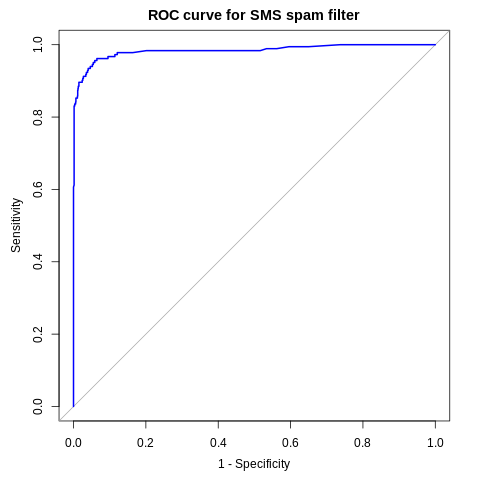

In [98]:
%%R
## Visualizing Performance Tradeoffs ----
install.packages("pRoc")
library(pROC)
sms_roc <- roc(sms_results$actual_type, sms_results$prob_spam)
# ROC curve for Naive Bayes
plot(sms_roc, main = "ROC curve for SMS spam filter", col = "blue", lwd = 2, legacy.axes = TRUE)

In this plot a ROC curve for the SMS example is shown. The diagonal grey line represents a model that only predicts by "chance" and therefore, has no predictive value, since it predicts TP's and FP's at the same rate. On the contrary, a model with perfect predictive value would go through the 100% TP-rate. The blue line depicts the SMS spam filter model which obviously has a very high predictive value. Simply put, the larger the area between the blue line and the grey line, the better the classifier. It is possible to calculate the area under the ROC curve **(AUC)**, whereas 0.5 represents a model with no predictive power and 1 a model with perfect predictive power. As the AUC can be the same for differently shaped curves, it is important not to use solely the AUC, but also other measures.  

It is also feasible to compare different models, for instance the k-NN model developed in chapter 3 with the Naive Bayes SMS classifier. 

In [100]:
#Lines 111-118



R[write to console]: Setting levels: control = ham, case = spam

R[write to console]: Setting direction: controls < cases

R[write to console]: Error in plot.xy(xy.coords(x, y), type = type, ...) : 
  plot.new has not been called yet
Calls: <Anonymous> ... <Anonymous> -> withVisible -> plot -> plot.roc -> plot.roc.roc




Error in plot.xy(xy.coords(x, y), type = type, ...) : 
  plot.new has not been called yet
Calls: <Anonymous> ... <Anonymous> -> withVisible -> plot -> plot.roc -> plot.roc.roc


As the area under the red line is obviously smaller, the k-NN approach is less powerful than the Naive Bayes model. This is also confirmed by the AUC.
However, it is not proven if the Naive Bayes model is still better if it is applied to another dataset. Hence, it is important to be able to estimate future performance, which will be the topic of the next section.